# **Credit Card Fraud Classification with Deep Learning (PyTorch)**

## **1- Data Preprocessing**

### 1.1-Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
# from imblearn.over_sampling import SMOTE

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import ReLU, Linear, BatchNorm1d, Dropout, Sequential, Module, BCEWithLogitsLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1.1- Importing Dataset

In [2]:
# import os
# import time

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# import torch
# from torch.nn import ReLU, Linear, BatchNorm1d, Dropout, Sequential, Module, BCEWithLogitsLoss
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

dataset = pd.read_csv('data/card_transdata.csv')
dataset = dataset.dropna()
dataset.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
dataset.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


**Dataset Correlation Heatmap**

<AxesSubplot:>

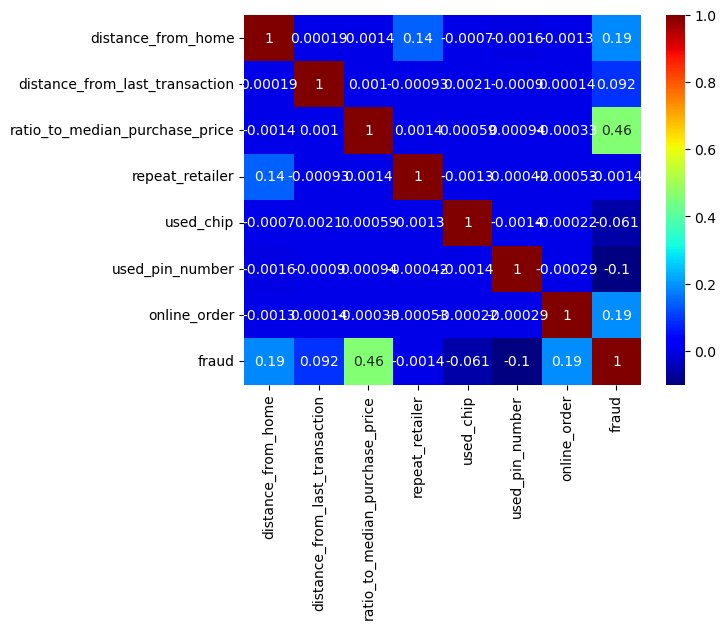

In [5]:
corr = dataset.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "jet")

fraud
0.0    912597
1.0     87403
dtype: int64

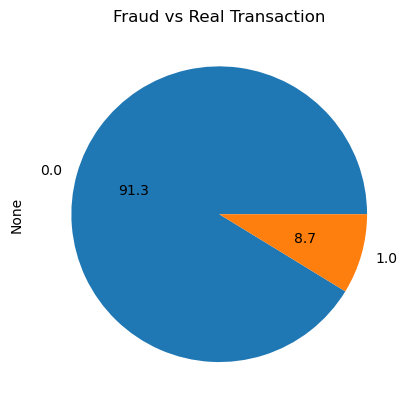

In [6]:
# Class distribution
# Real (class 0.0) meaning non-fraudulent transactions
# Fraud (class 1.0) meaning fraudulent transactions
dataset.value_counts("fraud").plot.pie(autopct = "%.1f", title = "Fraud vs Real Transaction")
dataset.value_counts("fraud")

# sns.set_context('paper', font_scale = 1)
# sns.set_style('ticks')
# sns.countplot(x ='fraud', data = dataset, palette ='deep')

`As it indicates, dataset is imbalanced`

**Down Sampling**

In [7]:
real = dataset[dataset["fraud"] == 0]
fraud = dataset[dataset["fraud"] == 1]

# Resampling the original dataset with 87,403 datapoints for both classes
real_resample = real.sample(n = 87403, random_state = 123)
fraud_resample = fraud.sample(n = 87403, random_state = 123)

# Creating new dataset consisting of equal class occurence 
dataset0 = pd.concat([real_resample, fraud_resample], axis = 0)

fraud
0.0    87403
1.0    87403
dtype: int64

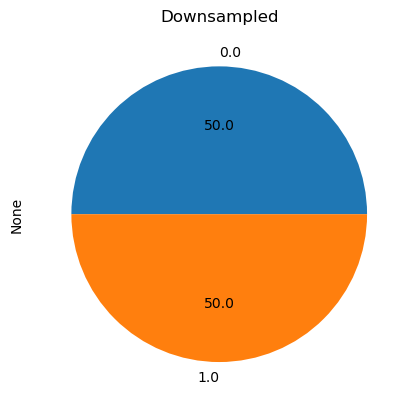

In [8]:
dataset0.value_counts("fraud").plot.pie(autopct = "%.1f", title = "Downsampled")
dataset0.value_counts("fraud")

We choose all columns as our matrix of features except the last one, which is 'y' column.

In [9]:
X = dataset0.iloc[:, : -1].values
y = dataset0.iloc[:, -1].values

In [10]:
dataset.fraud.value_counts()
print('Shape of X:', np.shape(X))
print('Shape of y:', np.shape(y))

Shape of X: (174806, 7)
Shape of y: (174806,)


### 1.3- Oversampling and Train, Test split

In [11]:
# X, y = SMOTE().fit_resample(X, y)
print('Shape of X:', np.shape(X))
print('Shape of y:', np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
print('\nX_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

Shape of X: (174806, 7)
Shape of y: (174806,)

X_train: (122364, 7)
y_train: (122364,)
X_test: (52442, 7)
y_test: (52442,)


## **2- Binary Classification**

In [12]:
def plt_acc_loss(train, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + plttype)
    plt.title('Training ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

### 2.1- Deep Learning

`Time to define Hyperparameters`

In [13]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.00146
WORKERS = 2
WD = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [19]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True, num_workers=WORKERS)

TypeError: Instance and class checks can only be used with @runtime_checkable protocols

### 2.2- Neural Network with 3 different layers

In [15]:
class NeuralNet(Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        # Number of input features is 7.
        self.layer_1 = Linear(7, 64) 
        self.layer_2 = Linear(64, 64)
        self.layer_out = Linear(64, 1) 

        self.relu = ReLU()
        self.dropout = Dropout(p=0.1)
        self.batchnorm1 = BatchNorm1d(64)
        self.batchnorm2 = BatchNorm1d(64)
          
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### 2.3- Training

In [17]:
start_time = time.time()

accuracy_stats = []
loss_stats = []

model = NeuralNet()
model.to(device)
loss = BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WD)

model.train()

for i in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        l = loss(y_pred, y_batch.unsqueeze(1))
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        epoch_loss += l.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {i:02d} / {EPOCHS:02d}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f}')
    loss_stats.append(epoch_loss / len(train_loader))
    accuracy_stats.append(epoch_acc / len(train_loader))


print('\nTraining is completed!')
print('_____________________________')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

NameError: name 'train_loader' is not defined

In [ ]:
plt_acc_loss(loss_stats, EPOCHS, 'Loss')

In [ ]:
plt_acc_loss(accuracy_stats, EPOCHS, 'Accuracy')

### 2.4- Testing

In [ ]:
start_time = time.time()

y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch_t, y_batch_t = X_batch.to(device), y_batch.to(device)
        y_test_pred = model(X_batch_t)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch_t.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

print('\Testing is completed!')
print('_____________________________')
print(f'Total Testing Time: {(time.time() - start_time)/60:.2f} min')

## **3- Classification Report**

In [ ]:
print('CLASSIFICATION REPORTS\n')
print(classification_report(y_true_list, y_pred_list))
print('\nCONFUSION MATRIX\n')
print(confusion_matrix(y_true_list, y_pred_list))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_true_list, y_pred_list) :.3f}')

In [ ]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list[: 30]),
    '$\hat{y}$': torch.FloatTensor(y_pred_list[: 30])
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))